In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import pickle as pkl# storing numpy features
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [2]:
import tensorflow
from keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import add
from keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout, Attention, MultiHeadAttention, LayerNormalization
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model

#### Import Train,Test,Val image names from given dataset  
 


In [3]:
# Define the path to the dataset
imgFolderPath='/kaggle/input/flicker8k-images/Flicker8k_Images/'
captionPath='/kaggle/input/flickr8k-text/Flickr8k_text/'
trainImageNames = open(captionPath+'Flickr_8k.trainImages.txt','r').read().splitlines()
valImageNames = open(captionPath+'Flickr_8k.valImages.txt','r').read().splitlines()
testImageNames = open(captionPath+'Flickr_8k.testImages.txt','r').read().splitlines()

# # Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print('Device available now:', device)


In [4]:
# read lemmatized text file into pandas DataFrame
df = pd.read_csv(captionPath+"Flickr8k.lemma.token.txt", sep="\t",header=None,names=['image_id','caption'])
df.head()

,image_id,caption
0,1305564994_00513f9a5b.jpg#0,A man in street racer armor be examine the tir...
1,1305564994_00513f9a5b.jpg#1,Two racer drive a white bike down a road .
2,1305564994_00513f9a5b.jpg#2,Two motorist be ride along on their vehicle th...
3,1305564994_00513f9a5b.jpg#3,Two person be in a small race car drive by a g...
4,1305564994_00513f9a5b.jpg#4,Two person in race uniform in a street car .


# **Caption Text Preprocessing Steps**
Convert sentences into lowercase \
Remove special characters and numbers present in the text \
Remove extra spaces \
Remove single characters \
Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [5]:
# define a function to preprocess the captions
def preprocess_caption(caption):
    # remove non-alphanumeric characters and convert to lowercase
    caption = caption.lower()
    caption = re.sub("[^A-Za-z]"," ",caption)
    caption = re.sub("\s+"," ",caption)
    caption = " ".join([word for word in caption.split() if len(word)>1 or word == 'a'])
    # caption = " ".join([word for word in caption.split() if len(word)>1])
    # add start and end tokens and return the preprocessed caption as a string
    return "startseq " + caption + " endseq"
    # return caption

# apply the preprocess_caption function to the caption column
print(df.iloc[0,1])
df["caption"] = df["caption"].apply(preprocess_caption)
print(df.iloc[0,1])

A man in street racer armor be examine the tire of another racer 's motorbike .
startseq a man in street racer armor be examine the tire of another racer motorbike endseq


In [6]:
lemmaText_maping={}

def calculate_mappings(row):
    id=row['image_id'][:-2]
    img_no=row['image_id'][-1]
    if img_no==str(0):
        lemmaText_maping[id]=[row['caption']]
    else:
        lemmaText_maping[id].append(row['caption'])

res=df.apply(calculate_mappings,axis=1)
lemmaText_maping['1305564994_00513f9a5b.jpg']

['startseq a man in street racer armor be examine the tire of another racer motorbike endseq',
 'startseq two racer drive a white bike down a road endseq',
 'startseq two motorist be ride along on their vehicle that be oddly design and color endseq',
 'startseq two person be in a small race car drive by a green hill endseq',
 'startseq two person in race uniform in a street car endseq']

### Sample Image with preprocessed captions

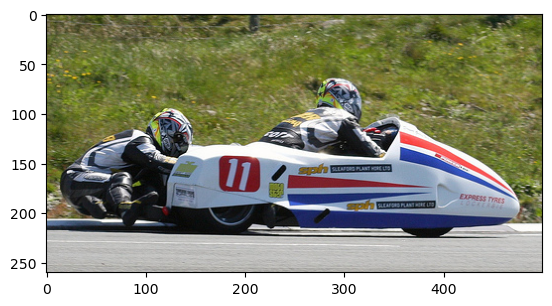

startseq a man in street racer armor be examine the tire of another racer motorbike endseq
startseq two racer drive a white bike down a road endseq
startseq two motorist be ride along on their vehicle that be oddly design and color endseq
startseq two person be in a small race car drive by a green hill endseq
startseq two person in race uniform in a street car endseq


In [7]:
x = plt.imread(imgFolderPath+'1305564994_00513f9a5b.jpg')
plt.imshow(x)
plt.show()
for i in lemmaText_maping['1305564994_00513f9a5b.jpg']:
    print(i)

### Extracting all train, test and val dataset captions 

In [8]:
trainText = {}
valText = {}
testText = {}
for i in trainImageNames:
    trainText[i] = lemmaText_maping[i]
for i in valImageNames:
    valText[i] = lemmaText_maping[i]
for i in testImageNames:
    testText[i] = lemmaText_maping[i]
print("Total no of images : ",len(lemmaText_maping))
print("no of train images : ",len(trainText))
print("no of validation images : ",len(valText))
print("no of test images : ",len(testText))

Total no of images :  8092
no of train images :  6000
no of validation images :  1000
no of test images :  1000


In [9]:
max_length = 0
for id,captions in lemmaText_maping.items():
    for i in captions:
        if(max_length < len(i.split())):
            max_length = len(i.split())
print("Length of longest caption : ",max_length)

Length of longest caption :  38


### Compute the vocabulary and word_index mapping

In [10]:
word_counts = {}
for id,captions in trainText.items():
    for i in captions:
        for w in i.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1
vocabulary = [w for w in word_counts if word_counts[w] >= 5]
print("Size of vocabulary : ",len(vocabulary))

Size of vocabulary :  2008


#### Assign indices to the words and vice-versa 

In [11]:
id_to_word = {}
word_to_id = {}
id = 1
for w in vocabulary:
    word_to_id[w] = id
    id_to_word[id] = w
    id += 1

vocab_size = len(id_to_word) + 1

#### Using Pretrained Embeddings from GloVe 6b 200d

In [12]:
# embeddings_index = {} 
# glove_file = open(os.path.join('/kaggle/input/glove6b/glove.6B.200d.txt'), encoding="utf-8")
# for line in glove_file:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# glove_file.close()

#### Convert the words into corresponding word embedding vectors

In [13]:
EMBEDDING_DIM = 200
# embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
# for word, idx in word_to_id.items():
#     embedding_vector = embeddings_index.get(word)
#     # words not found in embedding index will be all-zeros.
#     if embedding_vector is not None:
#         embedding_matrix[idx] = embedding_vector
# fid = open("embedding_matrix.pkl","wb")
# pkl.dump(embedding_matrix, fid)
# fid.close()

In [14]:
# # load embedding matrix from pickle
# with open('embedding_matrix.pkl', 'rb') as f:
#     embedding_matrix = pkl.load(f)

#load embedding matrix from pickle
with open('/kaggle/input/embedding-matrix/embedding_matrix.pkl', 'rb') as f:
    embedding_matrix = pkl.load(f)

# **Image Feature Extraction**

### **CNN model (ResNet50) for feature extraction from images**

In [15]:
# import tensorflow as tf
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply

# class Attention(tf.keras.layers.Layer):
#     def __init__(self):
#         super(Attention, self).__init__()
#         self.mlp = tf.keras.models.Sequential([
#             tf.keras.layers.Dense(2048, activation='relu'),
#             tf.keras.layers.Dense(1, activation='sigmoid')
#         ])
        
#     def call(self, inputs):
#         # inputs shape: [batch_size, num_features]
#         attention_weights = self.mlp(inputs)
#         # attention_weights shape: [batch_size, 1]
#         attention_weights = tf.expand_dims(attention_weights, axis=2)
#         # attention_weights shape: [batch_size, 1, 1, num_features]
#         attention_weights = tf.expand_dims(attention_weights, axis=2)
#         # attention_weights shape: [batch_size, 1, 1, num_features]
#         weighted_features = Multiply()([inputs, attention_weights])
#         # weighted_features shape: [batch_size, 1, 1, num_features]
#         output = tf.reduce_sum(weighted_features, axis=[1,2])
#         # output shape: [batch_size, num_features]
#         return output
    
# resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze the ResNet50 layers
# for layer in resnet.layers:
#     layer.trainable = True

# # Define the full model with attention
# inputs = tf.keras.layers.Input(shape=(224, 224, 3))
# x = resnet(inputs)
# x = GlobalAveragePooling2D()(x)
# x = Attention()(x)
# outputs = Dense(2048, activation='softmax')(x)
# cnn_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)


In [16]:
# Load the ResNet model and set it to inference mode
resnet = ResNet50(weights='imagenet', include_top=False,input_shape=(224,224,3),pooling='avg')
# resnet.trainable = False
# for layer in resnet.layers:
#     layer.trainable = True
# resnet.summary()

94765736/94765736 [==============================] - 1s 0us/step


In [17]:
cnn_model = Model(inputs=resnet.input, outputs=resnet.get_layer('avg_pool').output)
# cnn_model = Model(inputs=resnet.input, outputs=model.layers[-2].output)
# cnn_model.summary()

In [18]:
# Create an empty dictionary to store the features
features = {}

# Define the image transformations
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = preprocess_input(x)
    x=np.expand_dims(x, axis=0)
    return x

In [19]:
def extract_feature(name):
    image_path = os.path.join(imgFolderPath, name)
    image = preprocess_image(image_path)
    feature = cnn_model.predict(image,verbose=0)
    feature = np.reshape(feature, feature.shape[1])
    return feature

In [20]:
# len(trainImageNames)
# for i in range(2):
#     print(trainImageNames[i])
#     print(len(extract_feature(trainImageNames[i])))

In [21]:
# # Iterate through the images in the folder and extract their features using the ResNet model
# count=0
# for name in trainImageNames:
#     count+=1
#     feature=extract_feature(name)
#     features[name] = feature
#     if(count%500==0): print(count)
    
# # store features in pickle
# pkl.dump(features, open('img_features.pkl', 'wb'))

In [22]:
# # load features from pickle
# with open('img_features.pkl', 'rb') as f:
#     features = pkl.load(f)
    
# load features from pickle
with open('/kaggle/input/cnn-train-imgfeatures/img_features.pkl', 'rb') as f:
    features = pkl.load(f)

In [23]:
len(features)

6000

# **Generating Training Data for Progressive Loading**

In [24]:
def create_sequences(word_to_id, max_length, captions, img_feature, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for caption in captions:
        # encode the sequence
        seq = [word_to_id[word] for word in caption.split(' ') if word in word_to_id]
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            # import pdb; pdb.set_trace()
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(img_feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(np.squeeze(X1)), np.array(X2), np.array(y)

In [25]:
# data generator, intended to be used in a call to model.fit()
def data_generator(trainText, features, word_to_id, max_length, batch_size, vocab_size):
    # loop for ever over images
    current_batch_size=0
    while 1:
        for key, captions in trainText.items():
            # retrieve the photo feature
            if current_batch_size == 0:
                X1, X2, Y = list(), list(), list()
            img_feature = features[key]
            in_img, in_seq, out_word = create_sequences(word_to_id, max_length, captions, img_feature, vocab_size)
            #in_img = np.squeeze(in_img)
            X1.extend(in_img)
            X2.extend(in_seq)
            Y.extend(out_word)
            current_batch_size += 1
            if current_batch_size == batch_size:
                current_batch_size = 0
                yield [[np.array(X1), np.array(X2)], np.array(Y)]

In [26]:
# test the data generator
batch_size = 1
generator = data_generator(trainText,features, word_to_id, max_length, batch_size, vocab_size)
inputs,outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(50, 2048)
(50, 38)
(50, 2009)


# **LSTM Model Definition**

In [27]:
print(embedding_matrix.shape)
print(vocab_size)

(2009, 200)
2009


In [44]:
ip1 = Input(shape=(2048,))
feature_ext = Dropout(0.5)(ip1)
feature_ext = Dense(200, activation='relu')(feature_ext)
feature_ext2 = Reshape((1, 200), input_shape=(200,))(feature_ext)

ip2 = Input(shape=(max_length,))
seq_enc = Embedding(vocab_size, EMBEDDING_DIM,weights=[embedding_matrix],input_length=max_length, trainable=False, mask_zero=False)(ip2)
merged = concatenate([feature_ext2, seq_enc], axis=1)
seq_enc = LSTM(200)(merged)
seq_enc = Dropout(0.5)(seq_enc)


decoder1 = add([feature_ext, seq_enc])
decoder2 = Dense(200, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[ip1, ip2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout_7 (Dropout)            (None, 2048)         0           ['input_8[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 200)          409800      ['dropout_7[0][0]']              
                                                                                                  
 input_9 (InputLayer)           [(None, 38)]         0           []                               
                                                                                            

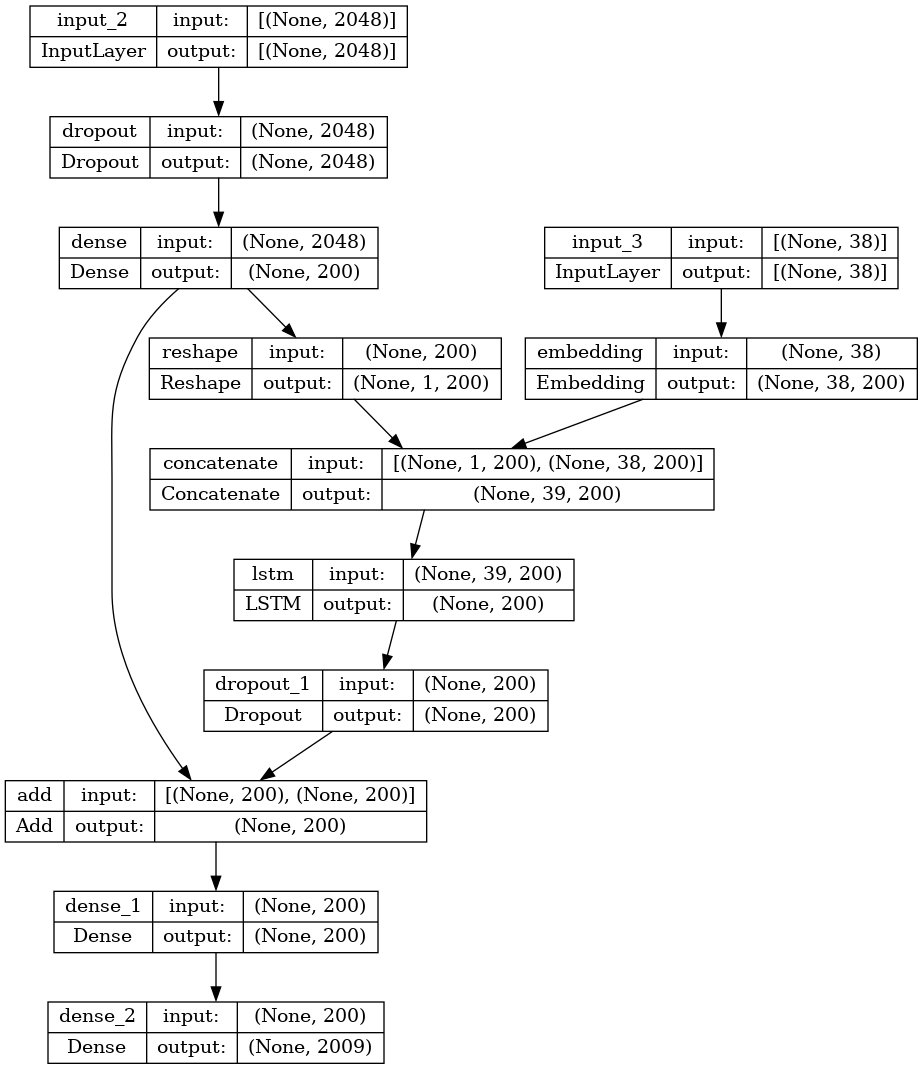

In [29]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, show_shapes=True)

### Modified Baseline with Attention

In [47]:


ip1 = Input(shape=(2048,))
ip2 = Input(shape=(max_length,))

feature_ext = Dropout(0.5)(ip1)
feature_ext  = Dense(200, activation='relu')(feature_ext )
feature_ext2 = Reshape((1, 200), input_shape=(200,))(feature_ext)

seq_enc = Embedding(vocab_size, EMBEDDING_DIM,weights=[embedding_matrix],input_length=max_length, trainable=False, mask_zero=False)(ip2)
seq_enc = LSTM(200, return_sequences=True)(seq_enc)

attention = MultiHeadAttention(num_heads=8, key_dim=64)(seq_enc, seq_enc, seq_enc)
attention = Dropout(0.5)(attention)
attention = LayerNormalization(epsilon=1e-6)(attention)

context = concatenate([attention, feature_ext2], axis=1)
seq_enc = LSTM(200)(context)
seq_enc = Dropout(0.5)(seq_enc)

decoder1 = add([feature_ext, seq_enc])
decoder2 = Dense(200, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[ip1, ip2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 38)]         0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 38, 200)      401800      ['input_15[0][0]']               
                                                                                                  
 input_14 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 lstm_9 (LSTM)                  (None, 38, 200)      320800      ['embedding_6[0][0]']            
                                                                                            

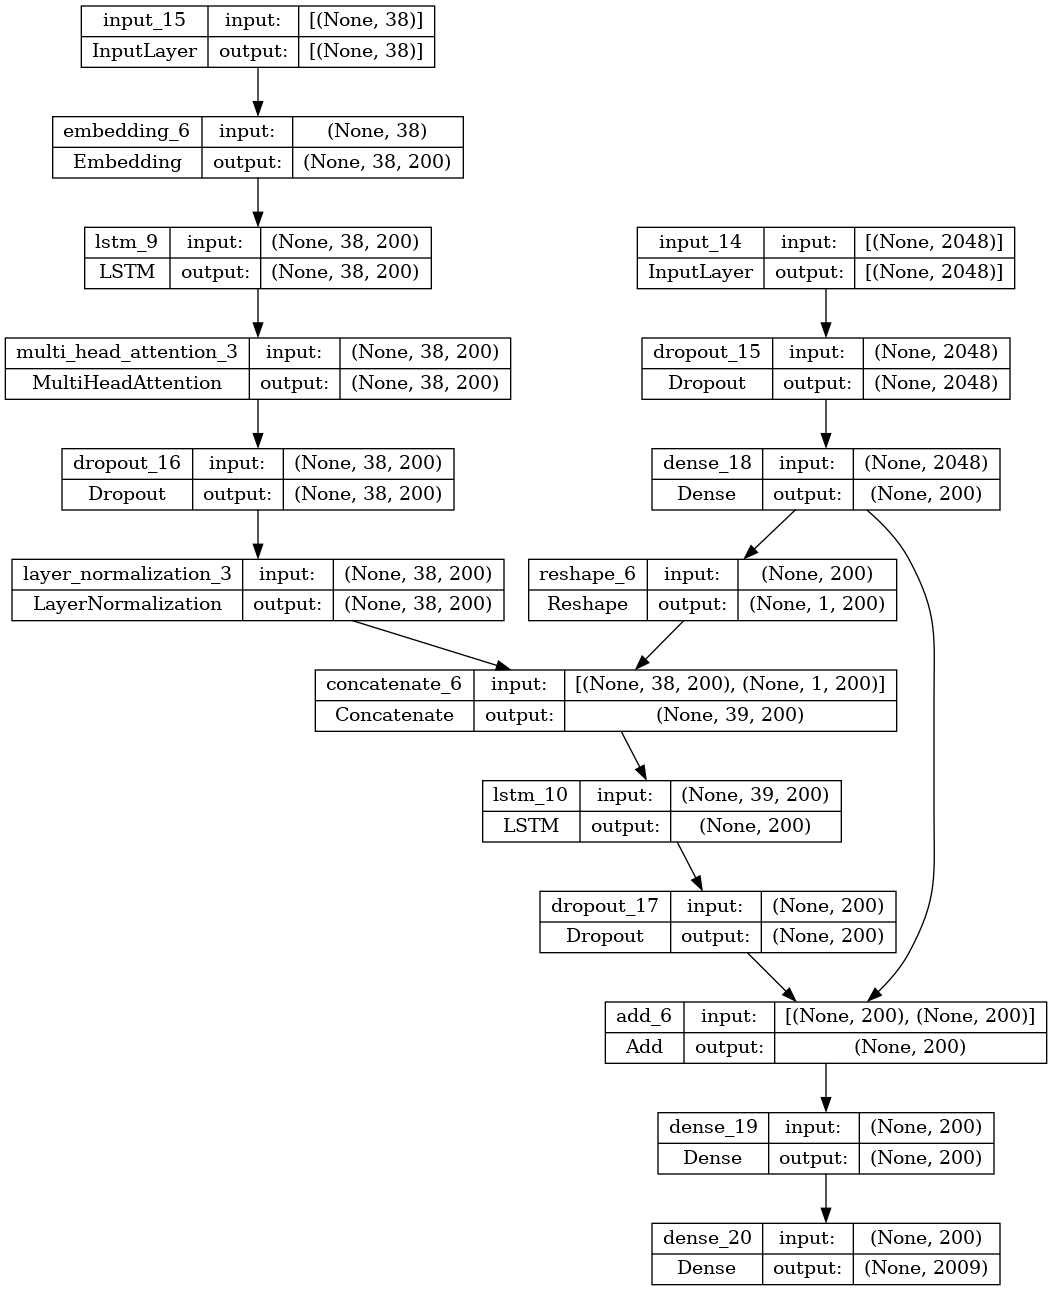

In [48]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, show_shapes=True)

In [32]:
# vision_input = Input(shape=(2048,))
# vision_feature1 = Dropout(0.5)(vision_input)
# vision_feature2 = Dense(256, activation='relu')(vision_feature1)

# caption_input = Input(shape=(max_length,))
# caption_embedding1 = Embedding(vocab_size, EMBEDDING_DIM,weights=[embedding_matrix],input_length=max_length, trainable=False, mask_zero=True)(caption_input)
# caption_embedding2 = Dropout(0.5)(caption_embedding1)
# caption_embedding3 = LSTM(256)(caption_embedding2)

# decoder1 = concatenate([vision_feature2, caption_embedding3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# model = Model(inputs=[vision_feature2, caption_embedding3], outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam')
# model.summary()

# Training Model(CNN-LSTM Network)
We use the progressive loading data generator to generate the training data on-the-fly. For each batch, we generate training data from 25 images.

In [33]:
epochs = 15
batch_size = 64
steps = len(trainText)//batch_size
steps_per_epoch = np.floor(steps/batch_size)

for i in range(epochs):
# create the data generator
    generator = data_generator(trainText,features, word_to_id, max_length, batch_size, vocab_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('modelConcat_1_' + str(i) + '.h5')

93/93 [==============================] - 53s 573ms/step - loss: 2.4846 - acc: 0.4284


In [ ]:
model = load_model('/kaggle/working/modelConcat_1_9.h5') 

# **Creating Captions using Trained Model**

In [34]:
#Removes start and end seq from test captions
def remove_seq(test_captions):
    for i in range(len(test_captions)):
        text = test_captions[i]
        word_list = text.split()
        word_list = word_list[1:-1]
        test_captions[i] = ' '.join(word_list)
    return test_captions

In [35]:
def greedySearch(vision_feature):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_to_id[w] for w in in_text.split() if w in word_to_id]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        yhat = model.predict([vision_feature,sequence], verbose=0)
        
        yhat = np.argmax(yhat)
        word = id_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

# Inferencing few captions on the test data

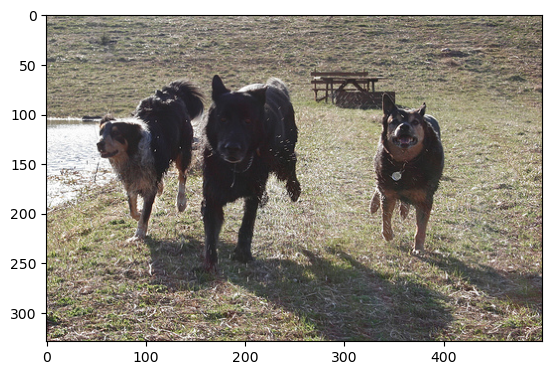

two dog be run through a beach
['startseq a group of dog run beside a pond through a field endseq', 'startseq several multicolored dog run through the grass endseq', 'startseq three black dog two with tan marking be run along grass endseq', 'startseq three dog run through a field endseq', 'startseq three dog run on scrubby grass a lake and picnic table nearby endseq']


In [36]:
image_name = testImageNames[100]
pred=extract_feature(image_name)
pred = pred.reshape(1,2048)

x = plt.imread(imgFolderPath+image_name)
plt.imshow(x)
plt.show()

prediction = greedySearch(pred)
print(prediction)
print(lemmaText_maping[image_name])

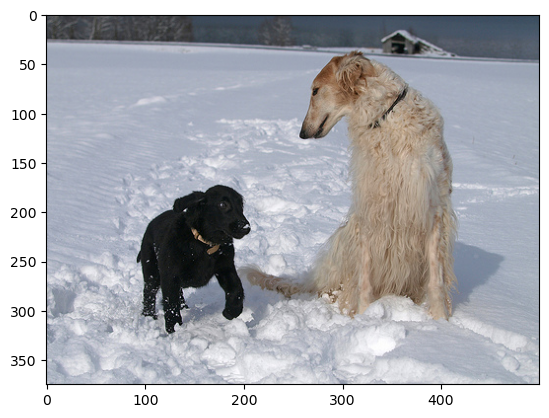

a black dog be run through the snow
['startseq a big white dog and a small black dog sit in the snow endseq', 'startseq a large white dog watch a little black dog run in the snow endseq', 'startseq a small dog and a large dog in the snow endseq', 'startseq a tall white dog sit and watch a small black dog run around him in the snow endseq', 'startseq a white dog look at a black puppy in the snow endseq']


In [37]:
image_name = testImageNames[91]
pred=extract_feature(image_name).reshape(1,2048)

x = plt.imread(imgFolderPath+image_name)
plt.imshow(x)
plt.show()

prediction = greedySearch(pred)
print(prediction)
print(lemmaText_maping[image_name])

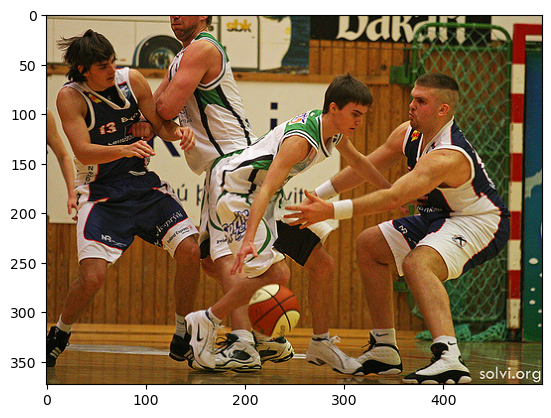

a basketball player in a white uniform be block a basketball in a basketball game
['startseq a player from white and green highschool team dribble down court defend by a player from the other team endseq', 'startseq four basketball player in action endseq', 'startseq four man play basketball two from each team endseq', 'startseq two boy in green and white uniform play basketball with two boy in blue and white uniform endseq', 'startseq young man play basketball in a competition endseq']


In [38]:
image_name = testImageNames[9]
pred=extract_feature(image_name).reshape(1,2048)

x = plt.imread(imgFolderPath+image_name)
plt.imshow(x)
plt.show()

prediction = greedySearch(pred)
print(prediction)
print(lemmaText_maping[image_name])

### Model Evaluation with BLEU scores 

In [39]:
def evaluate_model_greedy(image_list):
    scores = []
    predictions = []
    image_list = random.sample(image_list, 500)
    for image_name in tqdm(image_list): 
        pred = extract_feature(image_name).reshape(1,2048)
        
        prediction = greedySearch(pred)
        predictions.append(prediction)
        
        reference = testText[image_name].copy()
        reference = remove_seq(reference)

        score = sentence_bleu(reference, prediction)
        scores.append(score)
    return scores,predictions

In [40]:
g_scores,g_predictions = evaluate_model_greedy(testImageNames)

 57%|█████▋    | 284/500 [04:15<03:09,  1.14it/s]/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 500/500 [07:28<00:00,  1.11it/s]


# Average Bleu scores with greedy search  

In [41]:
np.mean(g_scores)

0.5993818330092506

### Meteor Score

In [42]:

# !pip install -U nltk


!pip install nltk==3.5

# nltk.data.path.remove('/usr/share/nltk_data/corpora')
nltk.download('wordnet', download_dir='/root/nltk_data')

from nltk.translate.meteor_score import meteor_score
def evaluate_model_greedy(image_list):
    scores = []
    predictions = []
    image_list = random.sample(image_list, 500)
    for image_name in tqdm(image_list): 
        pred = extract_feature(image_name).reshape(1,2048)
        
        prediction = greedySearch(pred)
        predictions.append(prediction)
        
        reference = testText[image_name].copy()
        reference = remove_seq(reference)

        score = meteor_score(reference, prediction)
        scores.append(score)
    return scores,predictions
g_scores,g_predictions = evaluate_model_greedy(testImageNames)
np.mean(g_scores)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
^C
ERROR: Operation cancelled by user
[nltk_data] Downloading package wordnet to /root/nltk_data...


ModuleNotFoundError: No module named 'nltk.translate.meteor_score'

### Beam Search

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [word_to_id["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [id_to_word[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
def evaluate_model_beam(image_list):
    scores = []
    predictions = []
    for image_name in tqdm(image_list[:200]):
        pred = extract_feature(image_name).reshape(1,2048)
    
        prediction = beam_search_predictions(pred, beam_index = 3)
        predictions.append(prediction)
        
        reference = testText[image_name].copy()
        reference = remove_seq(reference)

        score = sentence_bleu(reference, prediction)
        scores.append(score)
    return scores,predictions

In [ ]:
b_scores,b_predictions = evaluate_model_beam(testImageNames)

In [ ]:
np.mean(b_scores)